# Imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from umap import UMAP
from sklearn.metrics import pairwise_distances
from src.utils import load_data
import time
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import trustworthiness
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances

# autoreload for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Cleaned Dataset

We import the cleaned and processed dataset generated from the previous notebook (`data_cleaning.py`).
This dataset already contains only normalized or percentage-based quantitative features, and is ready for dimensionality reduction and clustering.


In [54]:
file_path = "cleaned_data/joueurs_ligue1_2024_2025_clean_custom.csv"
data_clean = load_data(file_path)
print("✅ Cleaned data loaded:", data_clean.shape)
data_clean.head()


Data loaded successfully from cleaned_data/joueurs_ligue1_2024_2025_clean_custom.csv
✅ Cleaned data loaded: (356, 131)


,equipe,player_name,player_id,player_country_code,positions,age,per90_gls,per90_ast,per90_non_pen_gls,per90_xg,...,second_yellow_cards_per90,fls_com_per90,fls_drawn_per90,offside_per90,pk_won_per90,pk_conceded_per90,og_per90,ball_recov_per90,air_dual_won_per90,air_dual_lost_per90
0,Saint,Gautier Larsonneur,b49729cb,FRA,GK,27.0,0.0,0.00,0.0,0.00,...,0.0,0.000000,0.382353,0.000000,0.0,0.000000,0.0,1.205882,0.205882,0.117647
1,Angers,Jordan Lefort,c3e4ecbb,FRA,DF,30.0,0.0,0.03,0.0,0.02,...,0.0,0.411765,0.441176,0.029412,0.0,0.029412,0.0,3.235294,1.176471,0.823529
2,Marseille,Gerónimo Rulli,625c144a,ARG,GK,32.0,0.0,0.00,0.0,0.00,...,0.0,0.058824,0.323529,0.000000,0.0,0.058824,0.0,1.088235,0.205882,0.029412
3,Lille,Lucas Chevalier,b3d76d84,FRA,GK,22.0,0.0,0.00,0.0,0.00,...,0.0,0.000000,0.205882,0.000000,0.0,0.000000,0.0,2.058824,0.176471,0.000000
4,Nice,Marcin Bułka,db87a2c4,POL,GK,24.0,0.0,0.00,0.0,0.00,...,0.0,0.000000,0.147059,0.000000,0.0,0.000000,0.0,1.823529,0.235294,0.000000


# Feature Extraction and Scaling

> For UMAP, all input variables should be numerical and comparable in scale. Although our data is mostly normalized (per-90 and percentages), we still standardize them to prevent small-scale differences from biasing distance calculations.

- `StandardScaler`: centers features and scales them by variance.  
- `RobustScaler`: less sensitive to outliers, using IQR instead of standard deviation.

We test both and keep the one producing a more balanced embedding (visually).

In [55]:
id_cols = ['player_name', 'equipe', 'positions', 'age', 'player_id', 'player_country_code']
feature_cols = [c for c in data_clean.columns if c not in id_cols]

X = data_clean[feature_cols].copy()

# Scaling option — choose between StandardScaler and RobustScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (356, 125)


# UMAP Dimensionality Reduction

> UMAP (Uniform Manifold Approximation and Projection) reduces the high-dimensional space into 2D or 3D while preserving both local and global structures of the data.

Key parameters:
- `n_neighbors`: controls the balance between local vs global structure.
- `min_dist`: controls compactness of clusters in the embedding.
- `metric`: defines the distance measure between data points (default: 'euclidean').


In [56]:
# Baseline UMAP configuration
umap_2d = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

start = time.time()
embedding_2d = umap_2d.fit_transform(X_scaled)
end = time.time()
print(f"UMAP 2D embedding computed in {end - start:.2f} seconds.")
print("UMAP embedding shape:", embedding_2d.shape)

# --- 3D UMAP ---
umap_3d = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric='euclidean',
    random_state=42
)

start = time.time()
embedding_3d = umap_3d.fit_transform(X_scaled)
end = time.time()
print(f"UMAP 3D embedding computed in {end - start:.2f} seconds.")
print("UMAP embedding shape:", embedding_3d.shape)

# Store result in DataFrame
umap_df = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])
umap_df = pd.concat([data_clean[id_cols].reset_index(drop=True), umap_df], axis=1)

umap_df.head()


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D embedding computed in 0.59 seconds.
UMAP embedding shape: (356, 2)


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 3D embedding computed in 0.60 seconds.
UMAP embedding shape: (356, 3)


,player_name,equipe,positions,age,player_id,player_country_code,UMAP_1,UMAP_2
0,Gautier Larsonneur,Saint,GK,27.0,b49729cb,FRA,20.179327,25.469830
1,Jordan Lefort,Angers,DF,30.0,c3e4ecbb,FRA,25.063856,-10.714072
2,Gerónimo Rulli,Marseille,GK,32.0,625c144a,ARG,20.068466,25.456457
3,Lucas Chevalier,Lille,GK,22.0,b3d76d84,FRA,20.268412,25.701078
4,Marcin Bułka,Nice,GK,24.0,db87a2c4,POL,20.089916,25.658903


# Quantitative Evaluation of UMAP Quality

We assess the quality of the UMAP embedding with several complementary metrics:

- **Trustworthiness**: measures how well local neighborhoods are preserved (higher = better).  
- **Continuity**: inverse measure of how many original neighbors are lost in the embedding.  
- **Distance correlation**: evaluates global distance relationships.  
- **MRRE (Mean Relative Rank Error)**: quantifies how much relative neighbor ranking is distorted.

In [57]:


def continuity(X, X_embedded, k=10):
    """Continuity score (Venna & Kaski, 2001)"""
    n = X.shape[0]
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_embedded)
    orig_neighbors = np.argsort(D_high, axis=1)[:, 1:k+1]
    emb_neighbors = np.argsort(D_low, axis=1)[:, 1:k+1]

    total = 0
    for i in range(n):
        orig = set(orig_neighbors[i])
        emb = set(emb_neighbors[i])
        missing = orig - emb
        total += sum([list(orig_neighbors[i]).index(m) + 1 for m in missing])
    return 1 - (2 / (n * k * (2 * n - 3 * k - 1))) * total


def mrre(X, X_embedded):
    """Mean Relative Rank Error"""
    n = X.shape[0]
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_embedded)

    R_high = np.argsort(np.argsort(D_high, axis=1), axis=1)
    R_low = np.argsort(np.argsort(D_low, axis=1), axis=1)

    error = np.abs(R_high - R_low) / np.maximum(R_high, 1)
    np.fill_diagonal(error, 0)
    return error.sum() / (n * (n - 1))


def evaluate_umap_quality(X_high, X_low, k=10):
    """Compute all manifold-preservation metrics."""
    trust = trustworthiness(X_high, X_low, n_neighbors=k)
    cont = continuity(X_high, X_low, k)
    corr, _ = spearmanr(pairwise_distances(X_high).ravel(),
                        pairwise_distances(X_low).ravel())
    mrre_score = mrre(X_high, X_low)
    return {
        'trustworthiness': trust,
        'continuity': cont,
        'distance_corr': corr,
        'mrre': mrre_score
    }




## Evaluate Baseline UMAP Quality

In [58]:
metrics = evaluate_umap_quality(X_scaled, embedding_2d, k=10)

print("🔍 UMAP Quality Metrics (2D):")
for k, v in metrics.items():
    print(f"{k:<18}: {v:.4f}")

🔍 UMAP Quality Metrics (2D):
trustworthiness   : 0.9185
continuity        : 0.9893
distance_corr     : 0.5592
mrre              : 0.6963


# Visualization of the 2D Embedding

We color the 2D UMAP projection by:
- Team (`equipe`)
- Position (`positions`)
- Age (continuous)

This helps assess whether the embedding separates players according to interpretable characteristics.


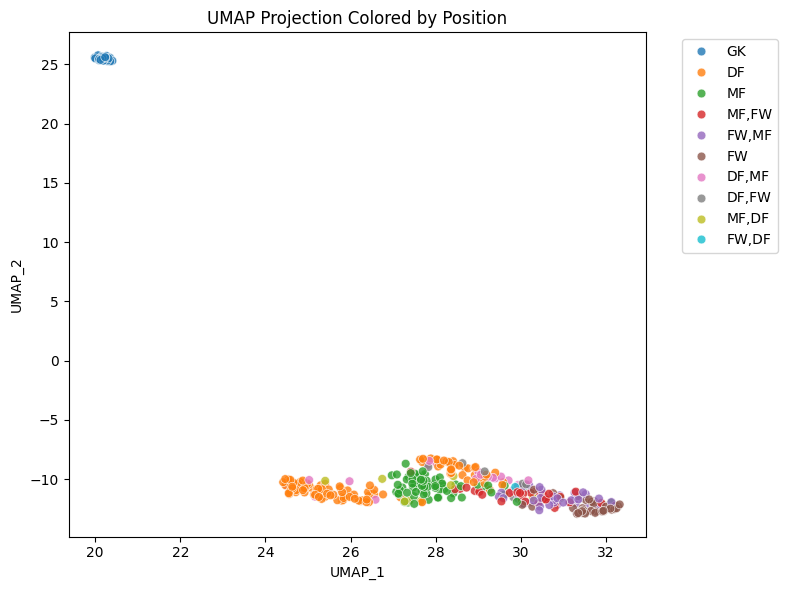

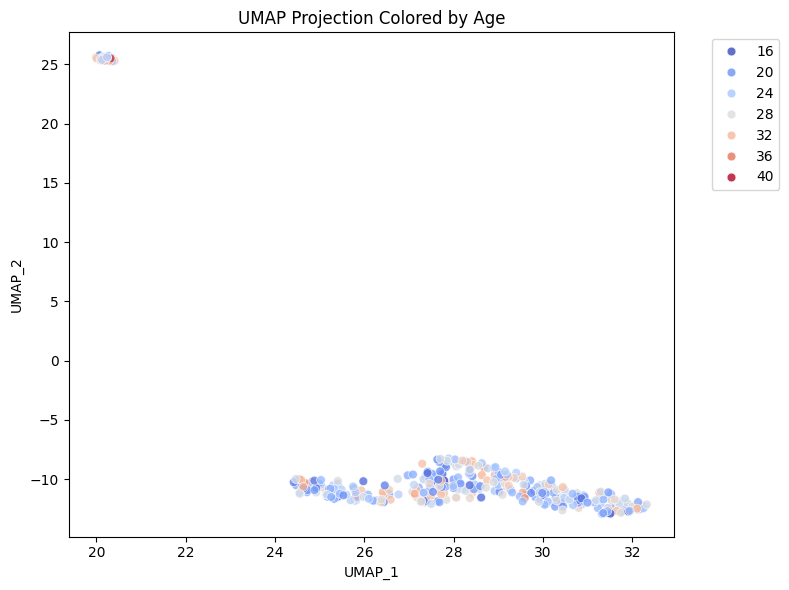

In [59]:
# Visualization of UMAP results
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df,
    x='UMAP_1', y='UMAP_2',
    hue='positions',
    palette='tab10',
    s=40, alpha=0.8
)
plt.title("UMAP Projection Colored by Position")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Age coloring
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df,
    x='UMAP_1', y='UMAP_2',
    hue='age',
    palette='coolwarm',
    s=40, alpha=0.8
)
plt.title("UMAP Projection Colored by Age")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Visualization of the 3D Embedding

We visualize the 3D embedding to explore additional structure in player similarity.


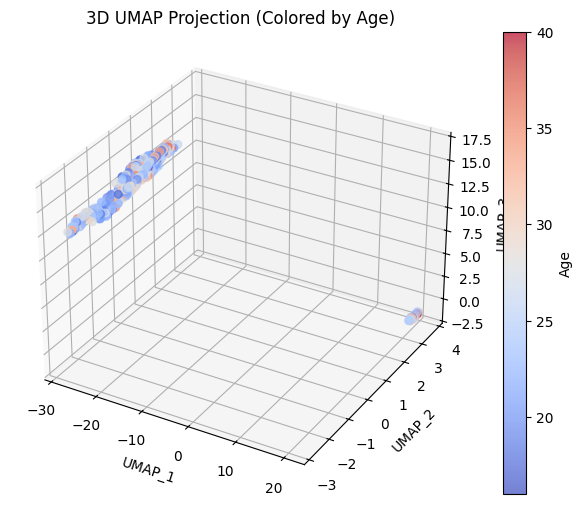

In [60]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=data_clean['age'], cmap='coolwarm', s=30, alpha=0.7
)
ax.set_xlabel('UMAP_1')
ax.set_ylabel('UMAP_2')
ax.set_zlabel('UMAP_3')
fig.colorbar(p, ax=ax, label='Age')
plt.title("3D UMAP Projection (Colored by Age)")
plt.show()

## Parameter Grid Search for UMAP Quality

We systematically vary `(n_neighbors, min_dist)` and evaluate
each embedding using the four quality metrics.



In [61]:
param_grid = {
    "n_neighbors": [5, 10, 15, 30, 50],
    "min_dist": [0.0, 0.1, 0.3, 0.5]
}

results = []

for nn in param_grid["n_neighbors"]:
    for md in param_grid["min_dist"]:
        reducer = UMAP(
            n_neighbors=nn,
            min_dist=md,
            n_components=2,
            metric='euclidean',
            random_state=42
        )
        emb = reducer.fit_transform(X_scaled)
        metrics = evaluate_umap_quality(X_scaled, emb, k=10)
        metrics.update({"n_neighbors": nn, "min_dist": md})
        results.append(metrics)
        print(f"✓ Done n_neighbors={nn}, min_dist={md}")

results_df = pd.DataFrame(results)
results_df


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=5, min_dist=0.0


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=5, min_dist=0.1


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=5, min_dist=0.3


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=5, min_dist=0.5


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=10, min_dist=0.0


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=10, min_dist=0.1


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=10, min_dist=0.3


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=10, min_dist=0.5


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=15, min_dist=0.0


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=15, min_dist=0.1


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=15, min_dist=0.3


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=15, min_dist=0.5


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=30, min_dist=0.0


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=30, min_dist=0.1


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=30, min_dist=0.3


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=30, min_dist=0.5


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=50, min_dist=0.0


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=50, min_dist=0.1


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=50, min_dist=0.3


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ Done n_neighbors=50, min_dist=0.5


,trustworthiness,continuity,distance_corr,mrre,n_neighbors,min_dist
0,0.922020,0.989158,0.576333,0.726840,5,0.0
1,0.917473,0.989045,0.578100,0.718330,5,0.1
2,0.913037,0.988987,0.575502,0.713214,5,0.3
3,0.916344,0.989031,0.594517,0.682661,5,0.5
4,0.919928,0.989812,0.532689,0.743471,10,0.0
5,0.924068,0.989856,0.538049,0.712918,10,0.1
6,0.914913,0.989558,0.601826,0.685182,10,0.3
7,0.911384,0.989473,0.559406,0.719843,10,0.5
8,0.920099,0.989338,0.554279,0.778544,15,0.0
9,0.918515,0.989318,0.559165,0.696316,15,0.1


## Composite Scoring

To summarize overall quality, we normalize metrics to [0,1]
(inverting MRRE so higher = better) and compute an average composite score.



In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
score_cols = ['trustworthiness', 'continuity', 'distance_corr']
scaled = scaler.fit_transform(results_df[score_cols])

mrre_scaled = 1 - MinMaxScaler().fit_transform(results_df[['mrre']])
composite = np.mean(np.column_stack([scaled, mrre_scaled]), axis=1)

results_df['composite_score'] = composite
results_df.sort_values('composite_score', ascending=False).head(10)


,trustworthiness,continuity,distance_corr,mrre,n_neighbors,min_dist,composite_score
10,0.915055,0.989166,0.602554,0.655047,15,0.3,0.755399
11,0.907662,0.989002,0.617592,0.641621,15,0.5,0.753194
6,0.914913,0.989558,0.601826,0.685182,10,0.3,0.743117
3,0.916344,0.989031,0.594517,0.682661,5,0.5,0.678742
5,0.924068,0.989856,0.538049,0.712918,10,0.1,0.635812
9,0.918515,0.989318,0.559165,0.696316,15,0.1,0.620242
0,0.922020,0.989158,0.576333,0.726840,5,0.0,0.604054
1,0.917473,0.989045,0.578100,0.718330,5,0.1,0.585082
2,0.913037,0.988987,0.575502,0.713214,5,0.3,0.557057
7,0.911384,0.989473,0.559406,0.719843,10,0.5,0.555727


## Heatmap Visualization of Quality Metrics

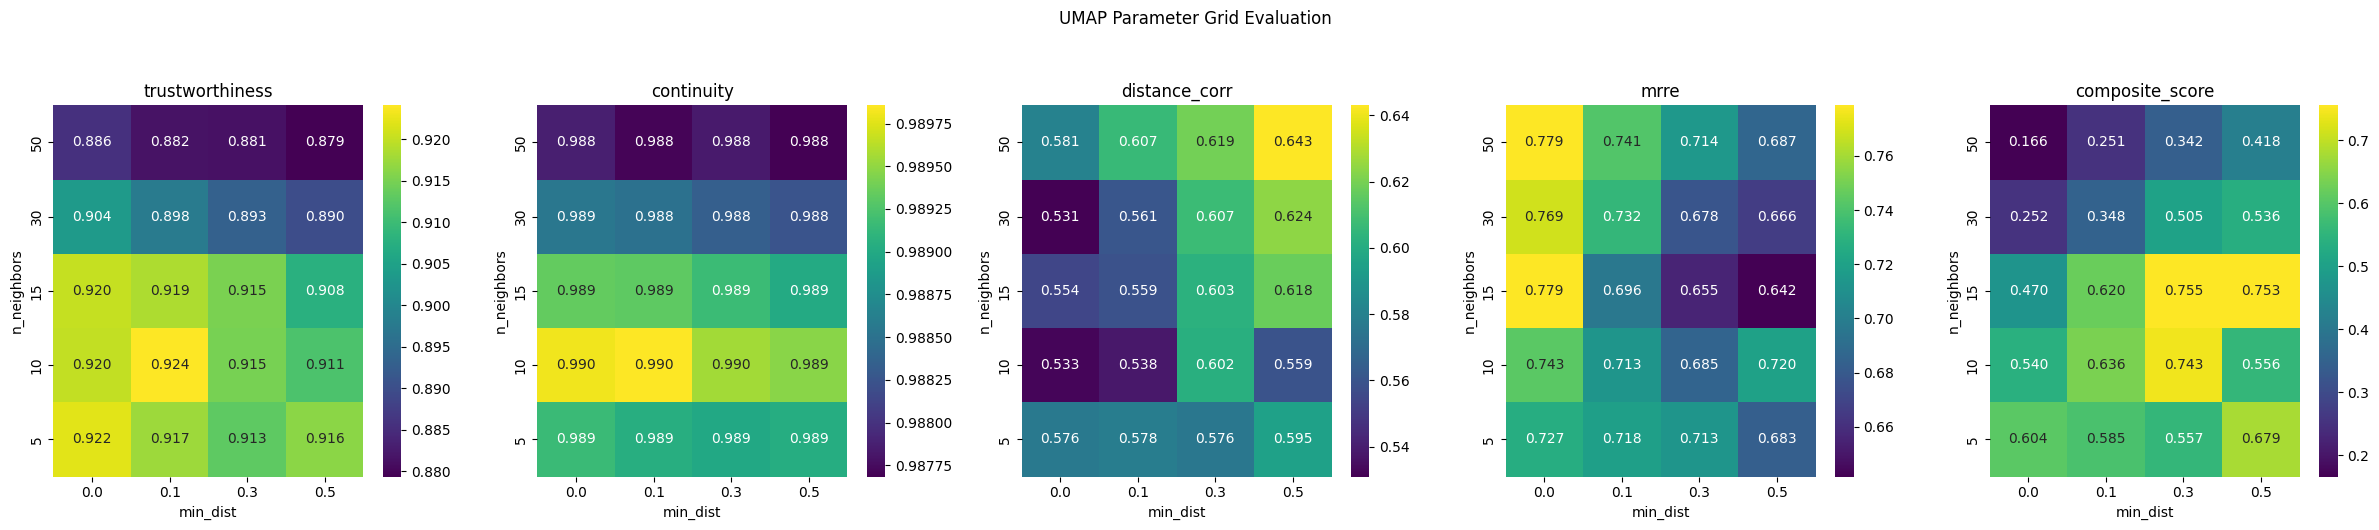

In [63]:
pivot_cols = ['trustworthiness', 'continuity',
              'distance_corr', 'mrre', 'composite_score']
fig, axes = plt.subplots(1, len(pivot_cols), figsize=(24, 5))

for i, metric in enumerate(pivot_cols):
    pivot = results_df.pivot(index='n_neighbors', columns='min_dist', values=metric)
    # pivot = results_df.pivot('n_neighbors', 'min_dist', metric)
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis', ax=axes[i])
    axes[i].set_title(metric)
    axes[i].invert_yaxis()

plt.suptitle("UMAP Parameter Grid Evaluation", y=1.05)
plt.tight_layout()
plt.show()

## Parameter Selection

We select the configuration with the highest composite score
and re-fit UMAP to generate the final 2D embedding.




In [64]:
best_params = results_df.loc[results_df['composite_score'].idxmax()]
print("🏆 Best UMAP configuration:")
print(best_params)

best_umap = UMAP(
    n_neighbors=int(best_params['n_neighbors']),
    min_dist=float(best_params['min_dist']),
    n_components=2,
    metric='euclidean',
    random_state=42
)
best_emb = best_umap.fit_transform(X_scaled)
umap_df[['UMAP_1', 'UMAP_2']] = best_emb


🏆 Best UMAP configuration:
trustworthiness     0.915055
continuity          0.989166
distance_corr       0.602554
mrre                0.655047
n_neighbors        15.000000
min_dist            0.300000
composite_score     0.755399
Name: 10, dtype: float64


c:\Users\Josephir\Documents\Josephir\Uni\UCBL\M2\DataMining\DataMining_Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



## Final Visualization with Optimal Parameters



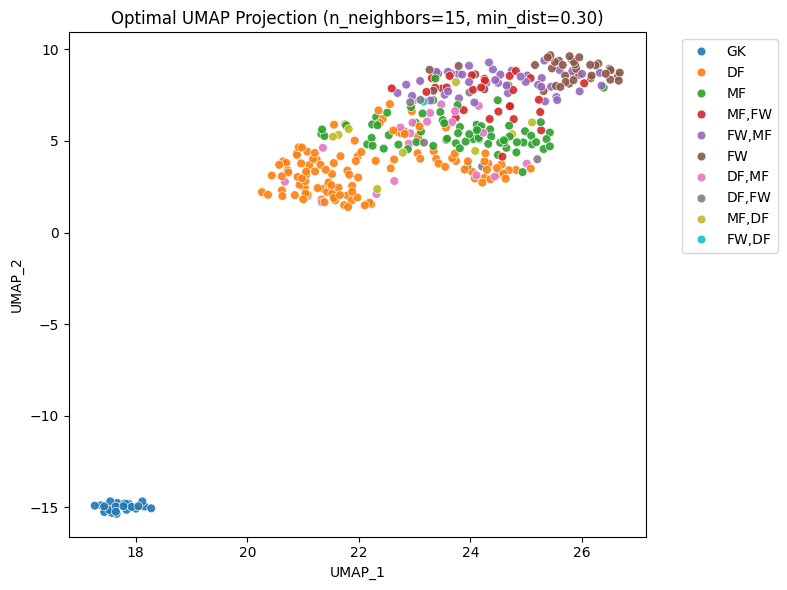

In [65]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=umap_df, x='UMAP_1', y='UMAP_2',
                hue='positions', palette='tab10', s=40, alpha=0.9)
plt.title(f"Optimal UMAP Projection (n_neighbors={int(best_params['n_neighbors'])}, "
          f"min_dist={float(best_params['min_dist']):.2f})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Saving the UMAP Embedding

The resulting embedding can be reused for clustering (DBSCAN, Agglomerative Clustering) and for visualization of cluster assignments later.


In [66]:
umap_df.columns.tolist()

['player_name',
 'equipe',
 'positions',
 'age',
 'player_id',
 'player_country_code',
 'UMAP_1',
 'UMAP_2']

In [67]:
output_path = "reduced_data/umap_embedding_2d.csv"
umap_df.to_csv(output_path, index=False)
print(f"✅ 2D UMAP embedding exported to {output_path}")


✅ 2D UMAP embedding exported to reduced_data/umap_embedding_2d.csv


# Summary

- **Data scaling:** standardized to ensure fair distance computation.  
- **UMAP application:** reduced high-dimensional feature space to 2D while preserving structure.  
- **Visualization:** revealed grouping tendencies by position and age.  
- **Next step:** apply clustering algorithms (DBSCAN and Agglomerative) on the UMAP coordinates to detect player style groups.
